In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Impostiamo un seed per la riproducibilità
np.random.seed(42)

df = pd.read_csv('ordini_cleaned.csv',delimiter = ';')
df['Data_mat'] = pd.to_datetime(df['Data_mat'])
df = df.drop(['Data_ricarica','C_CLI','Nominativo'],axis = 1)

C:\Users\antonio.proietti\AppData\Local\Temp\ipykernel_18648\750345659.py:9: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ordini_cleaned.csv',delimiter = ';')
C:\Users\antonio.proietti\AppData\Local\Temp\ipykernel_18648\750345659.py:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Data_mat'] = pd.to_datetime(df['Data_mat'])


## Data Augmentation

In [2]:
full_attivi_cessati = pd.read_excel('Full Attivi Cessati - 202410.xlsx')

c:\Users\antonio.proietti\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
full_attivi_cessati = full_attivi_cessati[full_attivi_cessati['TIPO DIPENDENTE'] == "DIPENDENTE - NON DIRIGENTE"]

KeyError: 'TIPO DIPENDENTE'

In [ ]:
full_attivi_cessati = full_attivi_cessati[['CID','CONTRATTO_COLLETTIVO', 'QUALIFICA',
    'GIORNI_SETTIMANALI', 'TURNISTA',
    'PERCENTUALE_PARTTIME', 'FIDUCIARIO', 'REPERIBILITA', 'SMART_WORKING',
    'CODICE_STRUTT_ORG','CODICE_MANSIONE']]


In [ ]:
full_unique = full_attivi_cessati.drop_duplicates(subset=['CID'], keep='first')

In [ ]:
df_merged = pd.merge(df, full_unique, left_on = 'CID', right_on = 'CID', how = 'left' )

In [ ]:
df = df_merged

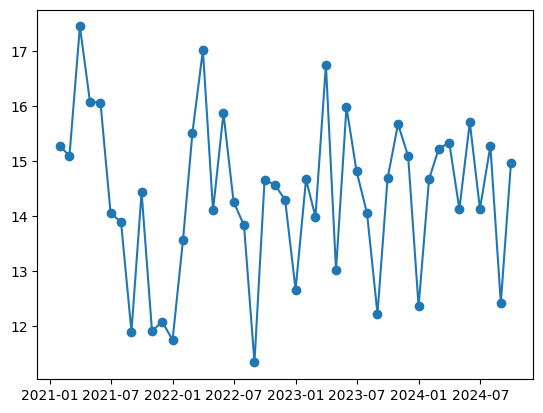

In [ ]:
df_grouped = df.groupby('Data_mat').mean('Qt').reset_index()
plt.plot(df_grouped['Data_mat'],df_grouped['Qt'],marker = 'o')
plt.xlabel = 'Periodo'
plt.ylabel = 'media quantità'
plt.show()


In [ ]:
df  = df.reset_index()

In [ ]:
Q1 = df['Qt'].quantile(0.25)
Q3 = df['Qt'].quantile(0.75)
IQR = Q3 - Q1

clip_low = Q1 - 1.5 * IQR
clip_high = Q3 + 1.5 * IQR

In [ ]:
print(f'Low boundary is {clip_low}\n high boundary is {clip_high}')

Low boundary is -10.0
 high boundary is 38.0


In [ ]:
df['Qt'] = df['Qt'].apply(lambda x: 40 if x > 40 else x)
df['Qt'] = df['Qt'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
df = df.loc[df['Qt'] != 0]

In [ ]:
df['Qt'] = np.sqrt(df['Qt'])

In [ ]:
df['Qt_lag1'] = df['Qt'].shift(1)
#df['Qt_lag2'] = df['Qt'].shift(2)
#df['Qt_lag3'] = df['Qt'].shift(3)
df['Media_Mobile'] = df['Qt'].rolling(window=3).mean()

# Rimuovi le righe con valori NaN
df.dropna(inplace=True)

In [ ]:
df.columns

Index(['index', 'Azieda', 'CID', 'Qt', 'Valore', 'Data_mat', 'SEDE_DI_LAVORO',
       'CONTRATTO_COLLETTIVO', 'QUALIFICA', 'GIORNI_SETTIMANALI', 'TURNISTA',
       'PERCENTUALE_PARTTIME', 'FIDUCIARIO', 'REPERIBILITA', 'SMART_WORKING',
       'CODICE_STRUTT_ORG', 'CODICE_MANSIONE', 'Qt_lag1', 'Media_Mobile'],
      dtype='object')

In [ ]:
col_names = ['Azieda', 'SEDE_DI_LAVORO','Valore','CONTRATTO_COLLETTIVO', 'QUALIFICA', 'GIORNI_SETTIMANALI', 'TURNISTA',
       'PERCENTUALE_PARTTIME', 'FIDUCIARIO', 'REPERIBILITA', 'SMART_WORKING',
       'CODICE_STRUTT_ORG', 'CODICE_MANSIONE']
for i in col_names:
    df[i] = df[i].astype(str)

<Figure size 1200x600 with 0 Axes>

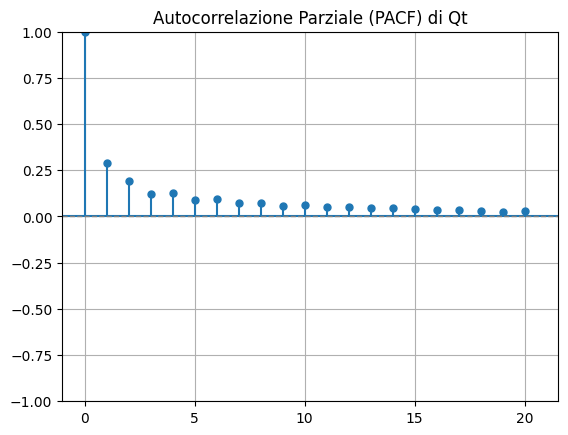

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf


plt.figure(figsize=(12, 6))
plot_pacf(df['Qt'], lags=20, alpha=0.05)
plt.title('Autocorrelazione Parziale (PACF) di Qt')

plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.grid()
plt.show()


In [ ]:
df['month'] = pd.DatetimeIndex(df['Data_mat']).month

In [ ]:
col_names.append('month')

In [ ]:
# Aggregazione dei dati per mese
df.set_index('Data_mat', inplace=True)


In [ ]:
df = df.sort_index(ascending = True)

In [ ]:
# Suddivisione in set di addestramento e di test
split_point = int(len(df)*0.8)
train = df[:split_point]
test = df[split_point:]

In [ ]:
y_train = train['Qt']
y_test = test['Qt']

In [ ]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols = col_names)
# Creiamo un DataFrame con le variabili codificate
train_encoded = encoder.fit_transform(train[col_names], train['Qt'])

test_encoded = encoder.transform(test[col_names])
# Visualizza il DataFrame codificato
print(train_encoded.head())

              Azieda  SEDE_DI_LAVORO    Valore  CONTRATTO_COLLETTIVO  \
Data_mat                                                               
2021-01-31  4.279348        3.102243  4.122658              3.721295   
2021-01-31  3.799745        3.526409  4.122658              3.721295   
2021-01-31  3.799745        3.526409  4.122658              3.721295   
2021-01-31  3.799745        3.526409  4.122658              3.721295   
2021-01-31  3.799745        3.526409  4.122658              3.721295   

            QUALIFICA  GIORNI_SETTIMANALI  TURNISTA  PERCENTUALE_PARTTIME  \
Data_mat                                                                    
2021-01-31   3.471839            3.487030   3.79532              3.591603   
2021-01-31   3.834525            3.972197   3.79532              3.591603   
2021-01-31   3.834525            3.972197   3.79532              3.591603   
2021-01-31   3.834525            3.972197   3.79532              3.591603   
2021-01-31   3.834525            

In [ ]:
train_encoded['Qt'] = y_train.values
test_encoded['Qt'] = y_test.values

In [ ]:
qt_columns = ['Qt_lag1',#'Qt_lag2','Qt_lag3',
'Media_Mobile']

In [ ]:
import xgboost as xgb

# Separazione delle variabili indipendenti dalla variabile target
X_train = train_encoded.drop(columns=['Qt'])
X_test = test_encoded.drop(columns=['Qt'])
for i in qt_columns:
    X_train[i] = train[i]
    X_test [i] = test[i]
y_train = train_encoded['Qt']
y_test = test_encoded['Qt']


In [ ]:
X_train.columns

Index(['Azieda', 'SEDE_DI_LAVORO', 'Valore', 'CONTRATTO_COLLETTIVO',
       'QUALIFICA', 'GIORNI_SETTIMANALI', 'TURNISTA', 'PERCENTUALE_PARTTIME',
       'FIDUCIARIO', 'REPERIBILITA', 'SMART_WORKING', 'CODICE_STRUTT_ORG',
       'CODICE_MANSIONE', 'month', 'Qt_lag1', 'Media_Mobile'],
      dtype='object')

In [ ]:
# Creazione del DMatrix per XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Impostazione dei parametri del modello
params = {
    'objective': 'reg:squarederror',  # Obiettivo di regressione per MAE
    'max_depth': 5,                        # Profondità massima degli alberi
    'learning_rate': 0.03,                  # Tasso di apprendimento
    'n_estimators': 100,                   # Numero di alberi
    'seed': 42
}


In [ ]:

# Allenamento del modello
model = xgb.train(params, dtrain, num_boost_round=63)

# Previsione
predictions = model.predict(dtest)

# Calcolo delle metriche di performance
mae = mean_absolute_error(y_test, predictions)

print(f'MAE: {mae:.2f}')

c:\Users\antonio.proietti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [17:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


MAE: 0.51


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Previsioni del modello XGBoost
xgb_predictions = model.predict(dtest)  # Assicurati di avere il tuo X_test correttamente definito

# Calcolo delle metriche
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print(f'XGBoost RMSE: {xgb_rmse:.2f}')
print(f'XGBoost MAE: {xgb_mae:.2f}')


XGBoost RMSE: 0.69
XGBoost MAE: 0.51


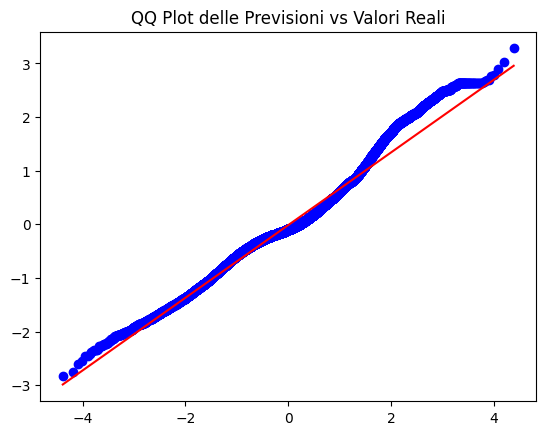

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calcola i quantili dei valori predetti e dei valori reali
xgb_predictions = pd.DataFrame(xgb_predictions)
xgb_predictions.columns = ['Qt']
xgb_predictions = xgb_predictions['Qt'].apply(lambda x: 1 if x < 1 else x)
stats.probplot(xgb_predictions - test_encoded['Qt'].values, dist="norm", plot=plt)

# Titolo e etichette
plt.title("QQ Plot delle Previsioni vs Valori Reali")


# Mostra il plot
plt.show()


- Provare ad aggiungere altre informazioni (es: qualifica, percentuale part time, etc)
- Provare ad aggiungere altri lag valutando l'ordine tramite BIC o AIC
- Provare a valutare l'impatto dell'aggiunta di alcune società (come break)

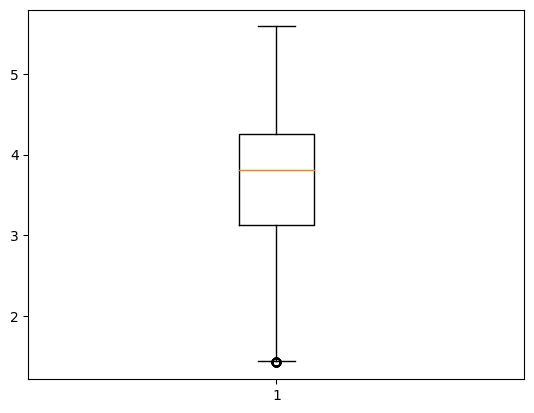

In [ ]:
plt.boxplot(xgb_predictions)
plt.show()

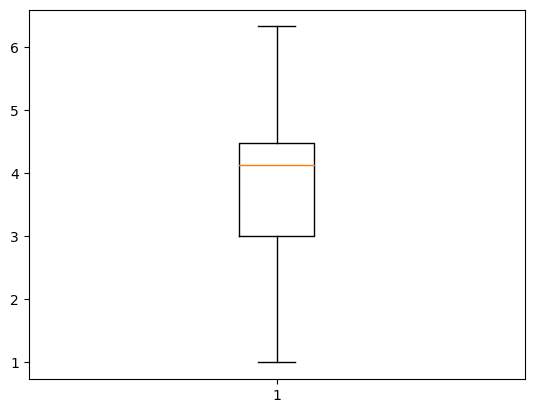

In [ ]:
plt.boxplot(test_encoded['Qt'])
plt.show()

In [ ]:
import joblib
#joblib.dump(model, 'model_rf.pkl')


In [ ]:
df.head()

,index,Azieda,CID,Qt,Valore,SEDE_DI_LAVORO,CONTRATTO_COLLETTIVO,QUALIFICA,GIORNI_SETTIMANALI,TURNISTA,PERCENTUALE_PARTTIME,FIDUCIARIO,REPERIBILITA,SMART_WORKING,CODICE_STRUTT_ORG,CODICE_MANSIONE,Qt_lag1,Media_Mobile,month
Data_mat,,,,,,,,,,,,,,,,,,,
2021-01-31,20220,AMSA SPA,10755,4.242641,730,OLGETTINA,CONTRATTO IGIENE URBANA,IMPIEGATO,5,Y,"100,00",Y,N,N,I10260,PI00805,4.358899,4.500173,1
2021-01-31,15231,APRICA SPA,900062,4.472136,730,BRESCIA - VIA CODIGNOLE,CONTRATTO IGIENE URBANA,OPERAIO,6,Y,"100,00",N,Y,N,G10070,PI00821,5.099020,4.190385,1
2021-01-31,15230,APRICA SPA,900056,5.099020,730,BRESCIA - VIA CODIGNOLE,CONTRATTO IGIENE URBANA,OPERAIO,6,Y,"100,00",N,Y,N,G10070,PI00688,3.000000,4.152639,1
2021-01-31,15229,APRICA SPA,900054,3.000000,730,BRESCIA - VIA CODIGNOLE,CONTRATTO IGIENE URBANA,OPERAIO,6,Y,"100,00",N,Y,N,G10017,PI00814,4.358899,4.119633,1
2021-01-31,15228,APRICA SPA,900053,4.358899,730,BRESCIA - VIA CODIGNOLE,CONTRATTO IGIENE URBANA,OPERAIO,6,Y,"100,00",N,Y,N,G10070,PI00821,5.000000,4.119633,1


In [ ]:
df.to_csv('DataFrame_Finale.csv')